In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [26]:
#Dtypes
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [27]:
#shape
df.shape

(1338, 7)

In [28]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

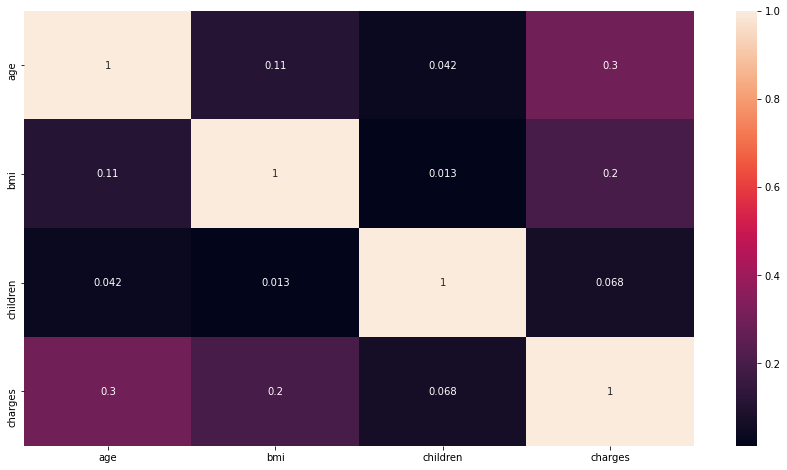

In [29]:
#multicollinearity
df_num = df.select_dtypes(include=np.number)
plt.figure(figsize=[15,8])
sns.heatmap(df_num.corr(),annot=True);

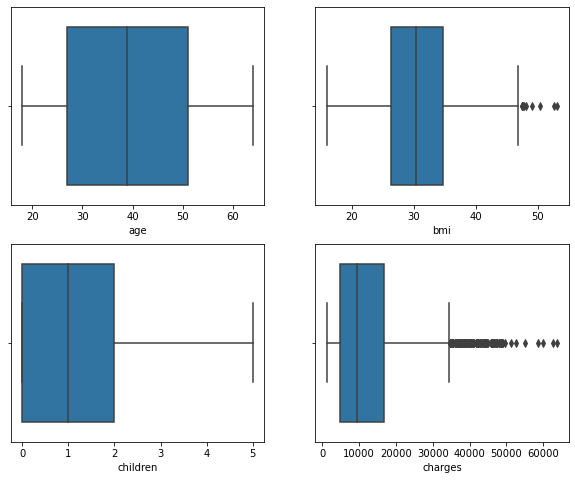

In [30]:
fig,ax=plt.subplots(2,2,figsize=(10,8))
for i,j in zip(df_num.columns,ax.flatten()):
    z=sns.boxplot(df_num[i],ax=j);
plt.show();

In [33]:
#transform charges and bmi
df['bmi'] = np.sqrt(df['bmi'])

In [36]:
df['charges'] = np.log(df['charges'])

In [37]:
df_num = df.select_dtypes(include=np.number)
import warnings
warnings.filterwarnings('ignore')

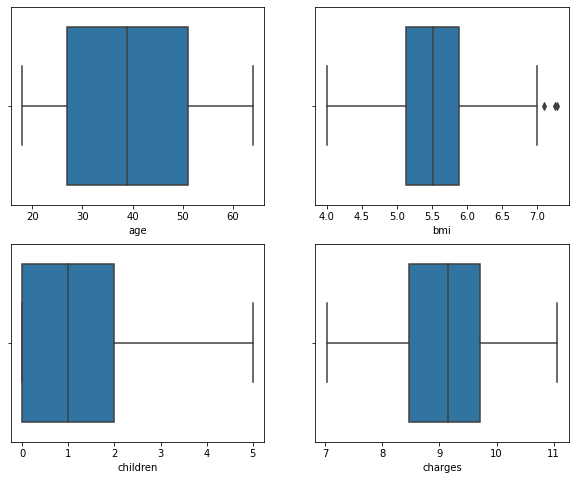

In [38]:
fig,ax=plt.subplots(2,2,figsize=(10,8))
for i,j in zip(df_num.columns,ax.flatten()):
    z=sns.boxplot(df_num[i],ax=j);
plt.show();

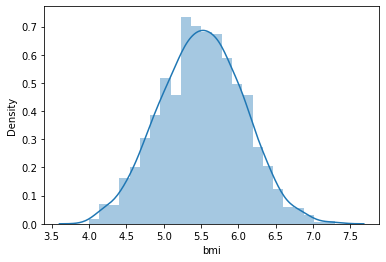

In [35]:
sns.distplot(df['bmi']);

In [34]:
import scipy.stats as st
st.skew(df['bmi'])

0.014131346186254976

In [39]:
st.shapiro(df['bmi'])

ShapiroResult(statistic=0.9985736012458801, pvalue=0.34463852643966675)

In [40]:
df_num = df.select_dtypes(include=np.number)
df_cat = df.select_dtypes(include='object')

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
sc=StandardScaler()
scaled = pd.DataFrame(sc.fit_transform(df_num),columns=df_num.columns)
dummies = pd.get_dummies(df_cat,drop_first=True)
df_new = pd.concat([scaled,dummies],axis=1)

In [44]:
#splitting to test and train
x = df_new.drop('charges',axis=1)
y = df_new['charges']
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.7,random_state=1)

In [45]:
#base model
import statsmodels.api as sm
base_model = sm.OLS(y_train,x_train).fit()
print(base_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.753
Model:                            OLS   Adj. R-squared (uncentered):              0.751
Method:                 Least Squares   F-statistic:                              353.7
Date:                Sun, 21 Nov 2021   Prob (F-statistic):                   1.15e-275
Time:                        15:18:43   Log-Likelihood:                         -674.53
No. Observations:                 936   AIC:                                      1365.
Df Residuals:                     928   BIC:                                      1404.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [47]:
#significant features
df_signi = pd.DataFrame()
df_signi['pval'] = base_model.pvalues
signi = df_signi[df_signi['pval']<0.05].index.to_list()
print("The significant variables are :",signi)
df_signi

The significant variables are : ['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']


,pval
age,4.115305e-146
bmi,2.491357e-09
children,1.624214e-14
sex_male,8.167768e-09
smoker_yes,8.252963e-215
region_northwest,1.995150e-08
region_southeast,2.557352e-18
region_southwest,4.622762e-16


In [49]:
#H0: Model is significant
#H0: Model is not significant

base_model.f_pvalue
#Not significant

1.1462947644691185e-275

In [51]:
#Y_pred
y_pred_base = base_model.predict(x_test)
from sklearn.metrics import mean_absolute_error,mean_squared_error
mse = mean_squared_error(y_pred_base,y_test)
rmse = np.sqrt(mse)
print("The RMSE value is: ",rmse)

The RMSE value is:  0.47147825080693445


In [53]:
mae = mean_absolute_error(y_pred_base,y_test)
mape = mae/len(y_train)*100
print("The MAE value is: ",mape)
print("The total sum of residue is :",np.sum(base_model.resid))

The MAE value is:  0.034754324050202
The total sum of residue is : -31.06651228950831


In [55]:
#check for multi collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF']=[variance_inflation_factor(x_train.values,i) for i in range(x_train.shape[1])]
vif['Features'] = x_train.columns
vif.sort_values('VIF',ascending=False)

,VIF,Features
3,1.649368,sex_male
6,1.326598,region_southeast
7,1.233052,region_southwest
4,1.219065,smoker_yes
5,1.200336,region_northwest
1,1.080555,bmi
0,1.019397,age
2,1.005206,children


In [58]:
#Forward selection
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
lr = LinearRegression()
linreg_for = sfs(estimator=lr,k_features='best',forward=True,scoring='r2')
linreg_for_model = linreg_for.fit(x_train,y_train)
print("The best params are :",linreg_for_model.k_feature_names_)
print("The score is :",linreg_for_model.k_score_)

The best params are : ('age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_southeast', 'region_southwest')
The score is : 0.7511366852573065


In [59]:
#Bckward
lr = LinearRegression()
linreg_back = sfs(estimator=lr,k_features='best',forward=False,scoring='r2')
linreg_back_model = linreg_back.fit(x_train,y_train)
print("The best params are :",linreg_back_model.k_feature_names_)
print("The score is :",linreg_back_model.k_score_)

The best params are : ('age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_southeast', 'region_southwest')
The score is : 0.7511366852573065


In [60]:
new_feat = list(linreg_for_model.k_feature_names_)
x_train_new = x_train[new_feat]
x_test_new = x_test[new_feat]
full_model = sm.OLS(y_train,sm.add_constant(x_train_new)).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     417.0
Date:                Sun, 21 Nov 2021   Prob (F-statistic):          1.91e-281
Time:                        15:30:28   Log-Likelihood:                -663.45
No. Observations:                 936   AIC:                             1343.
Df Residuals:                     928   BIC:                             1382.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.2208      0.030  

In [61]:
lr = LinearRegression()
lr_model = lr.fit(x_train_new,y_train)
lr_model.score(x_train_new,y_train)

0.7587914530224464

In [62]:
y_pred_full = lr_model.predict(x_test_new)
mse_test = mean_squared_error(y_test,y_pred_full)
rmse_test = np.sqrt(mse_test)
print("The RMSE value for test dataset is :",rmse_test)

The RMSE value for test dataset is : 0.4606062969408265


In [63]:
y_pred_full_train = lr_model.predict(x_train_new)
mse_train = mean_squared_error(y_train,y_pred_full_train)
rmse_train = np.sqrt(mse_train)
print("The RMSE value for train dataset is :",rmse_train)

The RMSE value for train dataset is : 0.49158235919130894


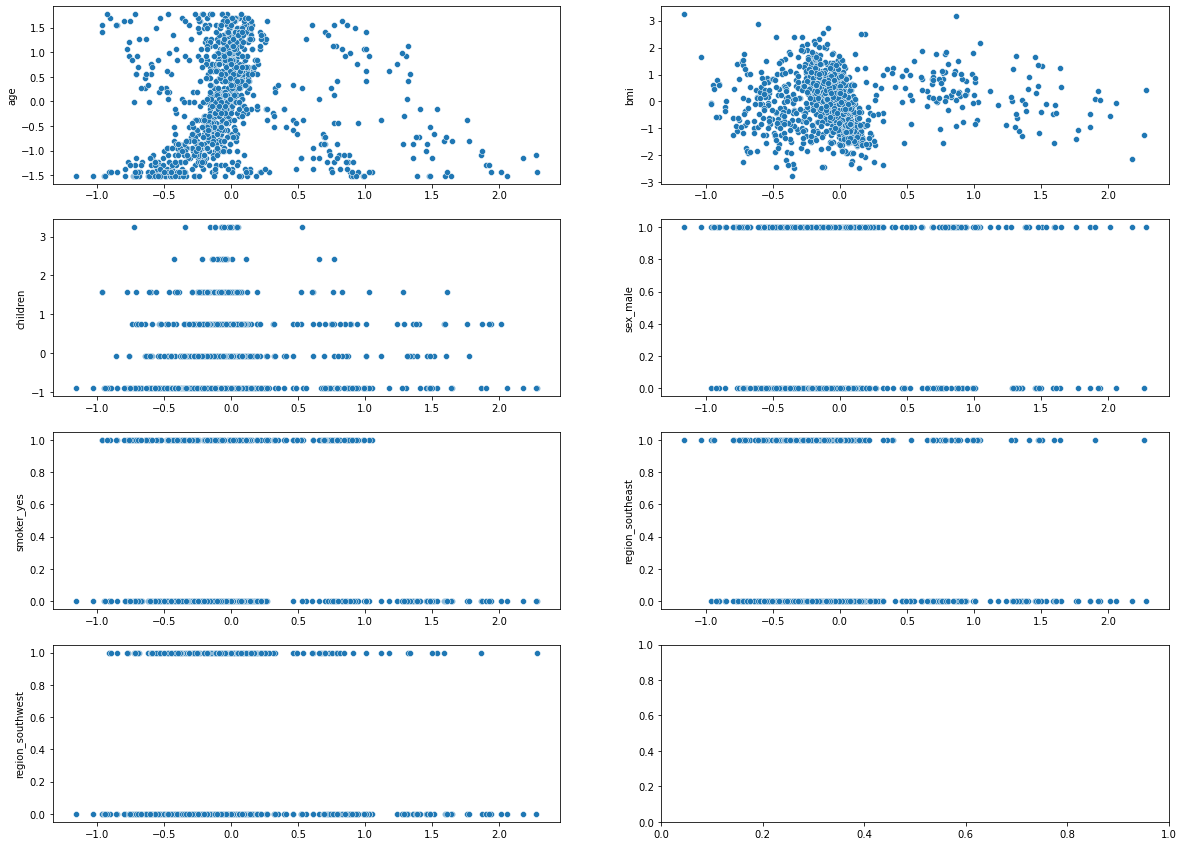

In [73]:
fig,ax=plt.subplots(4,2,figsize=(20,15))
for i,j in zip(x_train_new.columns,ax.flatten()):
    z=sns.scatterplot(x=full_model.resid,y=x_train_new[i],ax=j);
plt.show();

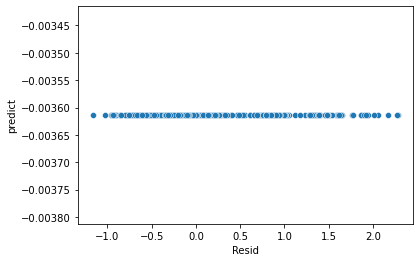

In [74]:
sns.scatterplot(full_model.resid,y_pred_full_train);
plt.xlabel('Resid');
plt.ylabel('predict');

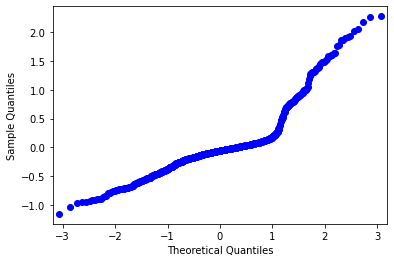

In [75]:
#Normality
from statsmodels.graphics.gofplots import qqplot
qqplot(full_model.resid);
#From the graph it is clear that it is normally distributed

In [76]:
st.shapiro(full_model.resid)

ShapiroResult(statistic=0.8403443098068237, pvalue=1.2713748170810063e-29)

In [77]:
st.skew(full_model.resid)

1.661933872353867

In [82]:
from sklearn.linear_model import SGDRegressor
sg = SGDRegressor()
sg_model = sg.fit(x_train_new,y_train)
sg_model.score(x_train_new,y_train)

0.7571476588599713

In [83]:
from sklearn.ensemble import GradientBoostingRegressor
gd = GradientBoostingRegressor()
gd_model = gd.fit(x_train_new,y_train)
gd_model.score(x_train_new,y_train)

0.873823899746811

In [84]:
y_pred_full = gd_model.predict(x_test_new)
mse_test = mean_squared_error(y_test,y_pred_full)
rmse_test = np.sqrt(mse_test)
print("The RMSE value for test dataset is :",rmse_test)

The RMSE value for test dataset is : 0.3619800435996003


In [85]:
y_pred_full_train = gd_model.predict(x_train_new)
mse_test = mean_squared_error(y_train,y_pred_full_train)
rmse_test = np.sqrt(mse_test)
print("The RMSE value for test dataset is :",rmse_test)

The RMSE value for test dataset is : 0.35554002078905045
